In [470]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import math 

df = pd.read_csv('./weather_data.csv')
df2 = pd.read_csv('./sea_level.csv')

df2 = df2.rename(columns={'min__sea_level (cm)':'max__sea_level (cm)'})

df = df.drop('Unnamed: 0', axis=1)
df2 = df2.drop('Unnamed: 0', axis=1)

Now that we have our two datasets, we need to join them. The attribute in common that we're considering is the day. 

In [471]:
# join dataframes 
df = df.join(df2.set_index('day'), on='Dates')

In [472]:
df.head()

,Dates,Temperature (° F) Max,Temperature (° F) Avg,Temperature (° F) Min,Dew Point (° F) Max,Dew Point (° F) Avg,Dew Point (° F) Min,Humidity (%) Max,Humidity (%) Avg,Humidity (%) Min,Wind Speed (mph) Max,Wind Speed (mph) Avg,Wind Speed (mph) Min,Pressure (Hg) Max,Pressure (Hg) Avg,Pressure (Hg) Min,Precipitation (in) Total,min_sea_level (cm),avg_sea_level (cm),max_sea_level (cm)
0,01/01/1997,41,37.4,34,34,10.3,0,87,80.0,75,23,5.2,0,30.1,29.9,29.8,0.0,6.0,56.70,87.0
1,02/01/1997,39,37.2,34,36,31.2,0,87,84.0,81,13,4.5,0,30.1,30.0,29.9,0.0,16.0,41.58,82.0
2,03/01/1997,43,39.5,0,37,35.0,0,87,80.1,0,13,6.8,0,29.9,28.7,0.0,0.0,17.0,51.58,104.0
3,04/01/1997,45,40.7,36,41,35.2,0,100,84.4,81,17,6.1,0,29.6,29.6,29.5,0.0,19.0,62.75,120.0
4,05/01/1997,43,40.4,39,37,35.8,34,87,82.9,81,7,1.7,0,29.9,29.7,29.6,0.0,-2.0,50.67,95.0


Our dataset it's still not ready, but at least it's finally here. We can now start with some feature engineering, then move onto data analysis and then we'll try to work with machine learning. 

I'm sorry fellows american, but Fahrenheit is not a metric that we europeans enjoy, so I'll start by converting temperatures back to celusius. 

In [473]:
# F to C formula
def f_to_c(value):
    return ((value-32)/1.8)

## Convert temperature rows from Fahrenheit to Celsius
def Temp_Conv(df):
    for index, row in df.iterrows():
        df.at[index, 'Temperature (° F) Max'] = f_to_c(df['Temperature (° F) Max'][index])
        df.at[index, 'Temperature (° F) Avg'] = f_to_c(df['Temperature (° F) Avg'][index])
        df.at[index, 'Temperature (° F) Min'] = f_to_c(df['Temperature (° F) Min'][index])
        df.at[index, 'Dew Point (° F) Max'] = f_to_c(df['Dew Point (° F) Max'][index])
        df.at[index, 'Dew Point (° F) Avg'] = f_to_c(df['Dew Point (° F) Avg'][index])
        df.at[index, 'Dew Point (° F) Min'] = f_to_c(df['Dew Point (° F) Min'][index])
    df = df.rename(columns={'Temperature (° F) Max': 'Temperature (° C) Max', 'Temperature (° F) Avg': 'Temperature (° C) Avg',
                       'Temperature (° F) Min': 'Temperature (° C) Min', 'Dew Point (° F) Max': 'Dew Point (° C) Max',
                       'Dew Point (° F) Avg': 'Dew Point (° C) Avg', 'Dew Point (° F) Min': 'Dew Point (° C) Min'})
    return df
df = Temp_Conv(df)

Let's take a peek at our data finally. We have 20 columns in total. Let's go over them quickly: 

1. **Dates**: This is the day where the measures takes place. It will surely be useful due to many information indirectly stored into it. As is its stored now it's hard to use properly, so I'll probably split the date into 3 columns: day, month and year.
2. **Temperature**: This is a daily measure of the temperature in Celsius. To make up to the fact that we need to analyze an entire day, which involves many temperature changes, we use maximum, minimum and average temperature of each day. 
3. **Dew Point**: The dew point represents the temperature to which air must be cooled to in order to reach saturation (assuming air pressure and moisture content are constant). The dew point can be used to measure the amount of moisture in the air. Once again, we consider the maximum, the minimum and the average. 
4. **Humidity**: Humidity is, in short, the amount of water vapor in the air. Usually on the report (as in our case) what is expressed is the so-called *relative humidity*, which is the amount of water vapor actually in the air, expressed as a percentage of the maximum amount of water vapor the air can hold at the same temperature. Once again, we consider the maximum, the minimum and the average. 
5. **Wind Speed**: pretty-much self explanatory, this is the speed which the wind have, masured in metres per hour. Once again, we consider the maximum, the minimum and the average. 
6. **Pressure**: This represent the air pressure, which identified as "the force per unit of area exerted on the Earth’s surface by the weight of the air above the surface." This is measured in inch of mercury (Hg).  Once again, we consider the maximum, the minimum and the average. 
7. **Precipitation**: this represents the mm of rain that have fallen. 
8. **Sea level**: This is the sea level registered at 'Punta della salute' in Venice. To help understand better this value, we defined the tide (considering measures in this particular place) as:

    1. *Sustained* if the sea level is between 80 and 109 cm above the sea;
    2. *Strongly sustained* if the sea level is between 110 and 139 cm above the sea;
    3. *Exceptional high-water* if the sea level is 140cm or more above the sea.
    
What we want to predict is whether or not there will be high-water, and the level that we'll expect from the tide. Therefore, we're in the scope of a supervised problem of binary classification and one of regression.

     

Let's now get a quick description of the data trough the pandas info() method.

In [474]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7938 entries, 0 to 7937
Data columns (total 20 columns):
Dates                       7938 non-null object
Temperature (° C) Max       7938 non-null int64
Temperature (° C) Avg       7938 non-null float64
Temperature (° C) Min       7938 non-null int64
Dew Point (° C) Max         7938 non-null int64
Dew Point (° C) Avg         7938 non-null float64
Dew Point (° C) Min         7938 non-null int64
Humidity (%) Max            7938 non-null int64
Humidity (%) Avg            7938 non-null float64
Humidity (%) Min            7938 non-null int64
Wind Speed (mph) Max        7938 non-null int64
Wind Speed (mph) Avg        7938 non-null float64
Wind Speed (mph) Min        7938 non-null int64
Pressure (Hg) Max           7938 non-null float64
Pressure (Hg) Avg           7938 non-null float64
Pressure (Hg) Min           7938 non-null float64
Precipitation (in) Total    7938 non-null float64
min_sea_level (cm)          7918 non-null float64
avg_sea_le

The majority of our data have numerical values, minus the date. Some sea levels are either missing or NaN, so we'll need to fix this later by either using median as a placeholder or removing the row. 
We can now take a look at the summary of the numerical attribues by using the pandas describe() method:

In [475]:
df.describe()

,Temperature (° C) Max,Temperature (° C) Avg,Temperature (° C) Min,Dew Point (° C) Max,Dew Point (° C) Avg,Dew Point (° C) Min,Humidity (%) Max,Humidity (%) Avg,Humidity (%) Min,Wind Speed (mph) Max,Wind Speed (mph) Avg,Wind Speed (mph) Min,Pressure (Hg) Max,Pressure (Hg) Avg,Pressure (Hg) Min,Precipitation (in) Total,min_sea_level (cm),avg_sea_level (cm),max_sea_level (cm)
count,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.0,7918.000000,7918.000000,7918.000000
mean,17.708491,14.117109,9.306248,11.767070,8.685941,3.282313,90.485135,73.755455,52.875535,12.680146,5.879617,1.152683,30.049811,29.869337,29.091119,0.0,-13.376358,29.813988,68.359939
std,8.482248,8.007571,8.569356,8.017119,8.281817,11.581388,9.413256,12.189284,19.048935,13.314916,3.193778,1.866562,1.145049,1.526021,4.923807,0.0,18.874075,13.261333,16.335222
min,-2.000000,-12.666667,-17.000000,-12.000000,-16.611111,-96.000000,44.000000,12.800000,0.000000,2.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,-83.000000,-14.000000,11.000000
25%,11.000000,7.333333,3.000000,6.000000,2.902778,-2.000000,87.000000,65.925000,43.000000,8.000000,3.800000,0.000000,29.900000,29.800000,29.800000,0.0,-26.000000,21.710000,58.000000
50%,17.000000,14.388889,10.000000,12.000000,9.777778,7.000000,93.000000,74.200000,53.000000,10.000000,5.400000,0.000000,30.100000,30.000000,29.900000,0.0,-14.000000,29.120000,68.000000
75%,25.000000,21.000000,17.000000,17.000000,15.555556,12.000000,100.000000,82.400000,65.000000,15.000000,7.300000,2.000000,30.200000,30.100000,30.100000,0.0,-1.000000,36.867500,78.000000
max,92.000000,31.055556,27.000000,97.000000,25.555556,23.000000,100.000000,100.000000,100.000000,921.000000,33.100000,20.000000,56.800000,30.800000,30.600000,0.0,76.000000,103.710000,154.000000


*count* is the number of samples. *mean* is quite obviously the mean value fo the feature, while *std* represents the standard deviation. The percentiles rows shows the value below which a given percentage of observations in a group of observations fall.

We can notice easily some things from here, i.e unrealistic data like a maximum temperature of 92° or the fact that data relatives to the precipitation are just a series of zeros. We can see that the high-water happens only <25% of the grandtotal of days recorded. 
We can also make some assumptions over the statistical attributes of the data. For example, similiar mean and std let us assume for a standrard distribution.

## Data pre processing
We can start by removing the precipitation column, since it's clearly useless.

In [476]:
# drop precipitation column
df = df.drop(['Precipitation (in) Total'], axis=1)

On the chance that Precipitation might actually turn useful for our analysis, I found additional data over the NOAA website. Let's add the precipitation to our data by loading the dataset and joining the table trough the data of the day:

In [477]:
# Lead the additional dataset
precipitation_data = pd.read_csv("weather.txt") 

# Extract date and Precipitation columns
precipitation_data = precipitation_data.iloc[:, [2, 19]]

Let's reformat the data attribute so that we can join the datasets:

In [478]:
# Reformat the data as in the other dataset
def date_formatter(dataset):  
    for index, row in dataset.iterrows():
        year, month, day = '', '', ''
        for i, c in enumerate(str(row[' YEARMODA'])):    
            if i<4:
                year = year+c
            elif 3<i<6:
                month = month+c
            else: day = day+c
        dataset.at[index, 'Date'] = str(day)+'/'+str(month)+'/'+str(year)
        
    return dataset

precipitation_data = date_formatter(precipitation_data)

# Drop the previous date column and rename precipitation column
precipitation_data = precipitation_data.drop([' YEARMODA'], axis=1)
precipitation_data = precipitation_data.rename(columns={'PRCP  ': 'Precipitation (inch)'})

# Join the datasets
df = df.join(precipitation_data.set_index('Date'), on='Dates')

We have to do some data processing over our new features. We can find the documentation of the data we've extracted [here](https://www7.ncdc.noaa.gov/CDO/GSOD_DESC.txt). In particular, we can see that missing values for the windspeed are expressed as a 999,9 value, while for the precipitation feature .00 indicates no measurable precipitation and 99.99 indicates missing values. There's also a flag which express additional information regarding the measure which we don't care about. We also use this chance to transform from inches to mm.

In [480]:
# Inches to mm formula
def i_to_mm(value):
    return (value*25.4)

# reformat the precipitation column 
for i, row in df.iterrows():
    j = 0
    new_entry = ''
    for c in str(row['Precipitation (inch)']):
        j += 1
        if j < 6 and c != ' ':
            new_entry = new_entry + c
    if new_entry == '99.99':
        df.at[i, 'Precipitation (inch)'] = 0
    elif math.isnan(float(new_entry)): 
        df.at[i, 'Precipitation (inch)'] = 0
    else: df.at[i, 'Precipitation (inch)'] = i_to_mm(float(new_entry))
        
df['Precipitation (mm)'] = pd.to_numeric(df['Precipitation (inch)'], errors='coerce')
df = df.drop('Precipitation (inch)', axis=1)

Let's also represent the dates by separing day, month and year, since we can imagine that some patterns or relations (like season cycles, which involves different meteorological phenomena) might be hidden in it. We can just drop the composed date afterwards since it's redundant. I doubt that the 'day' column will prove useful, but we'll keep it for now and eventually drop later on.

In [481]:
# split composed dates in days, months, and years
def date_separator(dataset):
    days, years, months = [], [], []
    
    for i, row in dataset.iterrows():
        day, month, year = row['Dates'].split('/')
        days.append(int(day))
        months.append(int(month))
        years.append(int(year))
     
    # add columns to dataframe
    dataset['Day'] = days
    dataset['Month'] = months
    dataset['Year'] = years
    return dataset

df = date_separator(df)

# drop dates column
df = df.drop(['Dates'], axis=1)

We can create a binary column that determine whether or not a day will have high-water, which we can use as target for the binary classification and for studies later on.

In [482]:
df.head()

,Temperature (° C) Max,Temperature (° C) Avg,Temperature (° C) Min,Dew Point (° C) Max,Dew Point (° C) Avg,Dew Point (° C) Min,Humidity (%) Max,Humidity (%) Avg,Humidity (%) Min,Wind Speed (mph) Max,...,Pressure (Hg) Max,Pressure (Hg) Avg,Pressure (Hg) Min,min_sea_level (cm),avg_sea_level (cm),max_sea_level (cm),Precipitation (mm),Day,Month,Year
0,5,3.000000,1,1,-12.055556,-17,87,80.0,75,23,...,30.1,29.9,29.8,6.0,56.70,87.0,21.590,1,1,1997
1,3,2.888889,1,2,-0.444444,-17,87,84.0,81,13,...,30.1,30.0,29.9,16.0,41.58,82.0,2.032,2,1,1997
2,6,4.166667,-17,2,1.666667,-17,87,80.1,0,13,...,29.9,28.7,0.0,17.0,51.58,104.0,9.906,3,1,1997
3,7,4.833333,2,5,1.777778,-17,100,84.4,81,17,...,29.6,29.6,29.5,19.0,62.75,120.0,0.000,4,1,1997
4,6,4.666667,3,2,2.111111,1,87,82.9,81,7,...,29.9,29.7,29.6,-2.0,50.67,95.0,0.000,5,1,1997


In [483]:
high = []
for i, row in df.iterrows():
    if row['max_sea_level (cm)'] > 80:
        high.append(1)
    else: high.append(0)
df['High Water'] = high

In [484]:
df.describe()

,Temperature (° C) Max,Temperature (° C) Avg,Temperature (° C) Min,Dew Point (° C) Max,Dew Point (° C) Avg,Dew Point (° C) Min,Humidity (%) Max,Humidity (%) Avg,Humidity (%) Min,Wind Speed (mph) Max,...,Pressure (Hg) Avg,Pressure (Hg) Min,min_sea_level (cm),avg_sea_level (cm),max_sea_level (cm),Precipitation (mm),Day,Month,Year,High Water
count,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000,...,7938.000000,7938.000000,7918.000000,7918.000000,7918.000000,7938.000000,7938.000000,7938.000000,7938.000000,7938.000000
mean,17.708491,14.117109,9.306248,11.767070,8.685941,3.282313,90.485135,73.755455,52.875535,12.680146,...,29.869337,29.091119,-13.376358,29.813988,68.359939,2.276625,15.715294,6.555556,2007.578231,0.193374
std,8.482248,8.007571,8.569356,8.017119,8.281817,11.581388,9.413256,12.189284,19.048935,13.314916,...,1.526021,4.923807,18.874075,13.261333,16.335222,8.002249,8.800653,3.442283,6.340054,0.394968
min,-2.000000,-12.666667,-17.000000,-12.000000,-16.611111,-96.000000,44.000000,12.800000,0.000000,2.000000,...,0.000000,0.000000,-83.000000,-14.000000,11.000000,0.000000,1.000000,1.000000,1997.000000,0.000000
25%,11.000000,7.333333,3.000000,6.000000,2.902778,-2.000000,87.000000,65.925000,43.000000,8.000000,...,29.800000,29.800000,-26.000000,21.710000,58.000000,0.000000,8.000000,4.000000,2002.000000,0.000000
50%,17.000000,14.388889,10.000000,12.000000,9.777778,7.000000,93.000000,74.200000,53.000000,10.000000,...,30.000000,29.900000,-14.000000,29.120000,68.000000,0.000000,16.000000,7.000000,2008.000000,0.000000
75%,25.000000,21.000000,17.000000,17.000000,15.555556,12.000000,100.000000,82.400000,65.000000,15.000000,...,30.100000,30.100000,-1.000000,36.867500,78.000000,0.000000,23.000000,10.000000,2013.000000,0.000000
max,92.000000,31.055556,27.000000,97.000000,25.555556,23.000000,100.000000,100.000000,100.000000,921.000000,...,30.800000,30.600000,76.000000,103.710000,154.000000,146.050000,31.000000,12.000000,2018.000000,1.000000


# Analyze by pivoting features

A good way to quickly analize your feature's correlation with one another is by pivoting them. This can help gain a lot of insight about previous assumptions over the data you had and create new ones. For example, we can see how the various months relates to high water phenomena:

In [485]:
df[['Month', 'High Water']].groupby(['Month'], as_index=True).mean().sort_values(by='High Water', ascending=False)

,High Water
Month,
11,0.409091
10,0.287812
12,0.243759
1,0.197853
3,0.194190
9,0.189681
2,0.179153
4,0.177273
5,0.168622


Looks pretty clear that during winter and spring, venice is more subjected to floodings. Guess splitting the date was useful after all! Let's look at the floodings per year:

In [486]:
df[['Year', 'High Water']].groupby(['Year'], as_index=True).mean().sort_values(by='High Water', ascending=False)

,High Water
Year,
2010,0.391781
2014,0.339726
2013,0.317808
2018,0.254795
2009,0.249315
2002,0.225275
2015,0.210959
2012,0.199454
2016,0.196721


The occurance of the high water phenomena has increased substantially over the years. This is probably correlated to the climate crisis.

# Data visualization

We should always try to visualize data whenever is possible, to discover statistical relations, trends or anomalies on data. One quick way to take a peek at the data is to use the .hist() function of pandas.

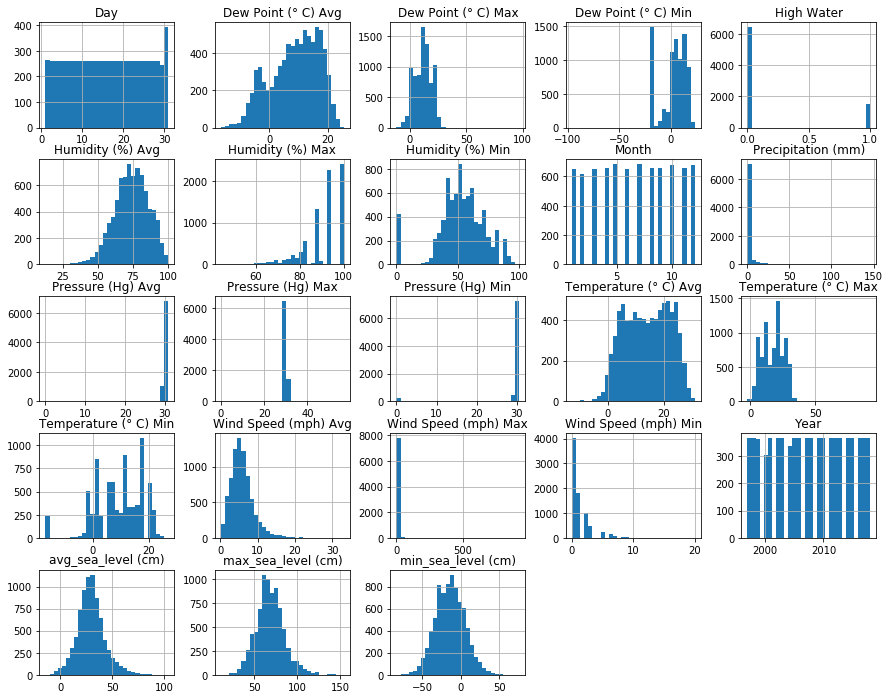

In [487]:
df.hist(bins=30, figsize=(15, 12))
plt.show()
plt.close()

We can clearly see that some features has bell curve distribution, while others like the average wind speed or humidity are left or right skewed, which indicates that there are outliers in the data. Some histogram may appear clunky due to the fixed size for every histogram, so we'll go later in detail for every feature.

By plotting the maximum sea level over the years as a strip plot we can see how the sea level vary across the years.

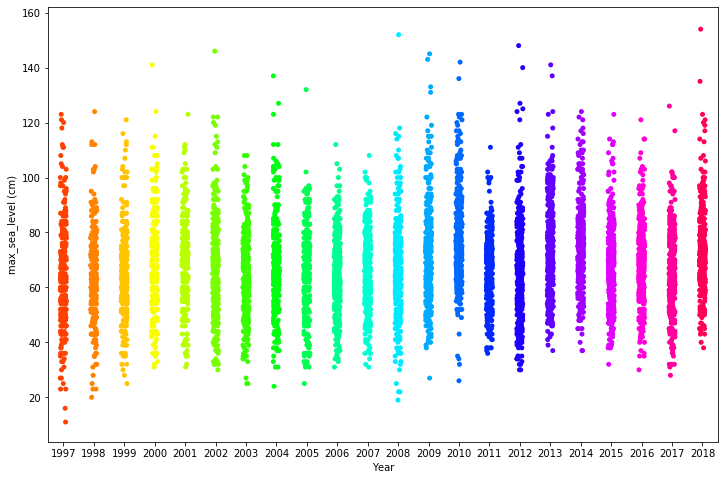

In [488]:
f, ax = plt.subplots(figsize=(12,8))
sn.stripplot(x="Year", y="max_sea_level (cm)", data=df,  ax=ax, palette="hsv")

Let's try to get  some additional insight by our data. By plotting a Pie chart we can quickly see that almost 21% of the days in venice features some form of flooding.

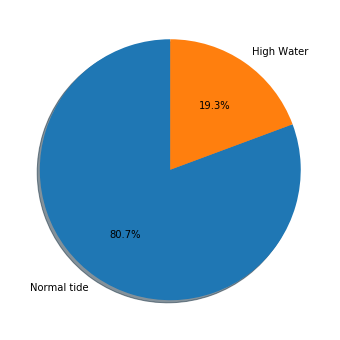

In [489]:
flood, noflood = df['High Water'].value_counts()
plt.figure(figsize=(12, 6))
plt.pie([flood, noflood],  labels=['Normal tide','High Water'], autopct='%1.1f%%',  shadow=True, startangle=90)
plt.show()

Out of those 20% of the days, the majority of it is just a sustained high water, (which luckily don't afctually create any problem to the citzen of Venice). Only less than the 15% is strongly sustained or expectional. To check this, we create a temporary column from which we'll count the different levels. 

In [490]:
level = []
for i, row in df.iterrows():
    
    if (row['max_sea_level (cm)'] >= 80 and row['max_sea_level (cm)'] < 110):
        level.append(1)
    elif (row['max_sea_level (cm)'] >= 110 and row['max_sea_level (cm)'] < 139):
        level.append(2)
    elif (row['max_sea_level (cm)'] >= 140):
        level.append(3)
    else: 
        level.append(0)

df['Water level'] = level

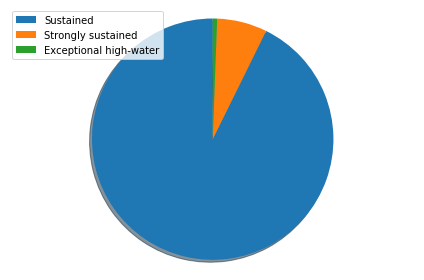

In [491]:
noflood, low, med, high = df['Water level'].value_counts()
labels=['Sustained', 'Strongly sustained', 'Exceptional high-water']
patches, texts = plt.pie([low, med, high],  shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

We might keep this column for additional uses afterwards, so I'll hold onto discard it for now.

Let's check the precipitation column. 

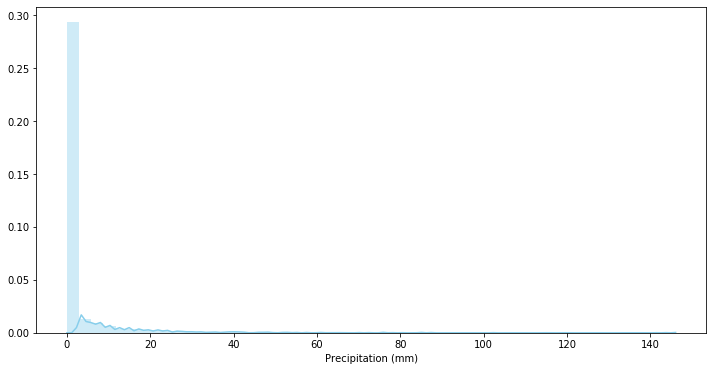

In [492]:
plt.figure(figsize=(12, 6))
sn.distplot( df["Precipitation (mm)"] , color="skyblue")

While the data might appear heavily skewed, we need to consider that in Venice only rain around 70 days over a year, so a similar result is understandable. 
It might be interesting to see how the rainy days influence the high water.

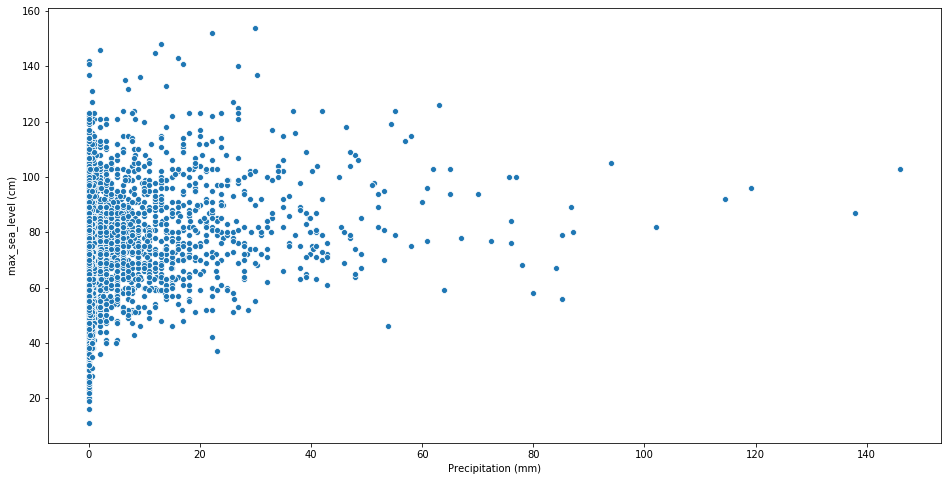

In [493]:
plt.figure(figsize=(16, 8))
sn.scatterplot(x="Precipitation (mm)", y="max_sea_level (cm)", data=df)

From the scatter plot, it doesn't appear to be a direct relation between the sea level and the precipitation, however by plotting the precipitation over the water level we can see that the high water phenomena occurs mostly whenever it rains more. A particular high error is however to be considered for the exceptional high water level.

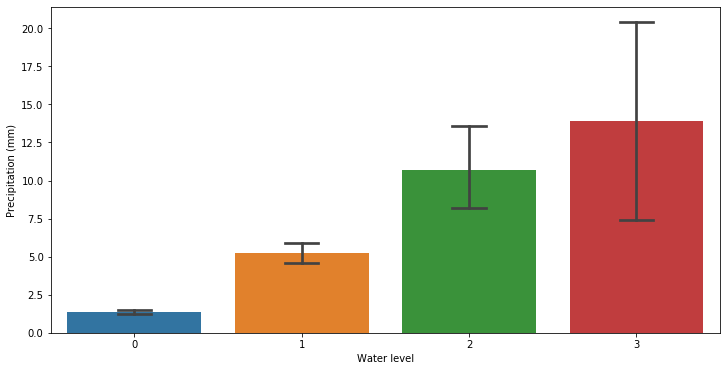

In [494]:
plt.figure(figsize=(12, 6))
sn.barplot(x="Water level", y="Precipitation (mm)", data=df, capsize=.2)

Let's analyze the temperature data. 

<Figure size 864x432 with 0 Axes>

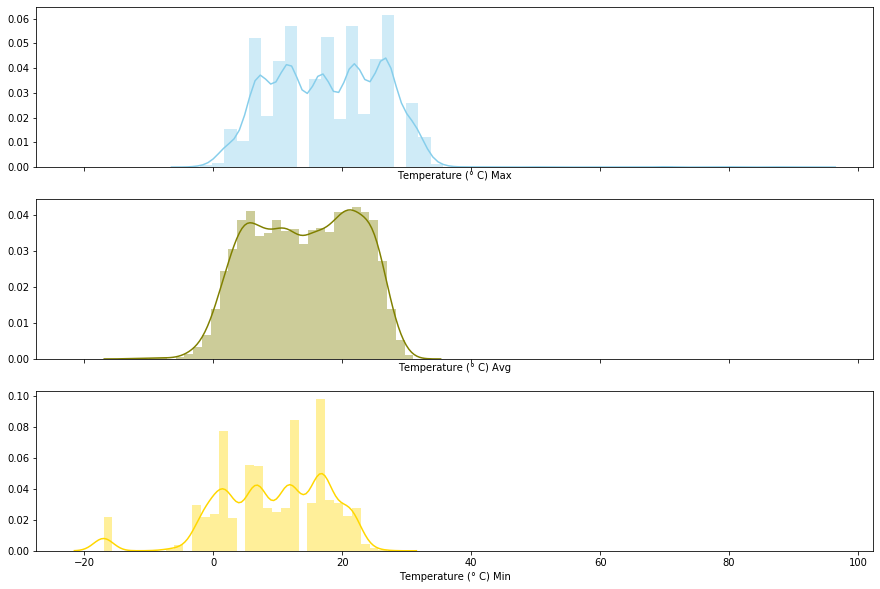

In [495]:
plt.figure(figsize=(12, 6))
f, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
sn.distplot( df["Temperature (° C) Max"] , color="skyblue", ax=axes[0])
sn.distplot( df["Temperature (° C) Avg"] , color="olive", ax=axes[1])
sn.distplot( df["Temperature (° C) Min"] , color="gold", ax=axes[2])

As we've saw previously, the data was positively skewed thus we can imagine about outliers. 
One easy way to splot outliers is by plotting a boxplot considering the temperatures over the months.

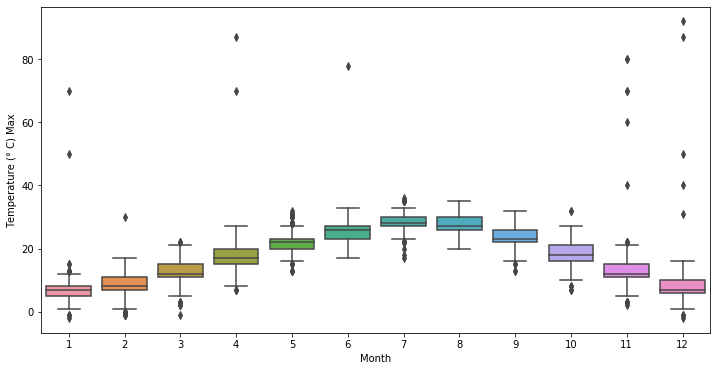

In [496]:
plt.figure(figsize=(12, 6))
sn.boxplot(x="Month", y="Temperature (° C) Max", data=df)

Seems pretty unreasonable to me that we could have over 40° in December, so it's pretty safe to assume there must be some error on the retrieval of the data which may husrt our prediciton. I'll proceed by removing those data. I'll use a null value as a placeholder for now. 

On the other hand, plotting a Box Plot for  the minimum temperatures shows that there an anomaly that shows each moth has an unreasonable temperature < 20°. Clearly an error which we'll fix by placing a null value as a placeholder once again.   

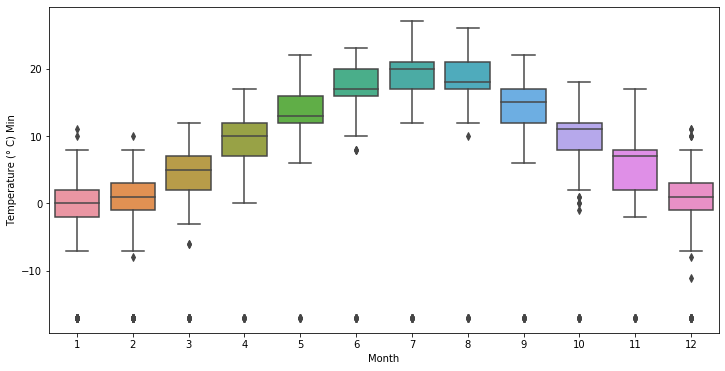

In [497]:
plt.figure(figsize=(12, 6))
sn.boxplot(x="Month", y="Temperature (° C) Min", data=df)

Since the highest and the lowest temperature ever recorded for venice are 37° and 12°, I'll use this as a treshold.

By taking a quick comparison between the temperature and the water level in Venice, we can see that heavier forms of floodings happens when the temperature is usually lower.

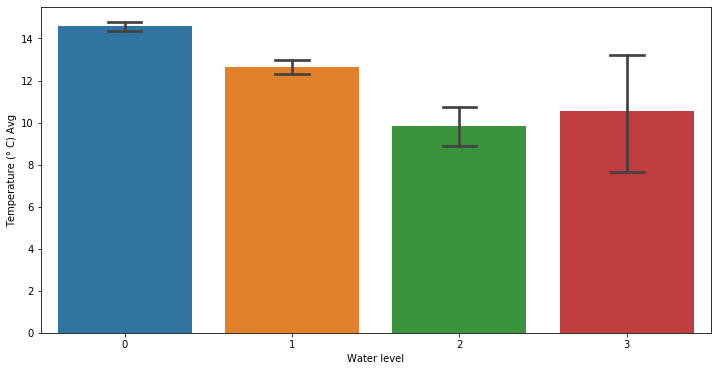

In [498]:
plt.figure(figsize=(12, 6))
sn.barplot(x="Water level", y="Temperature (° C) Avg", data=df, capsize=.2)

Wind speed is clearly skewed too. Wind speed is less than 30 (mph) in Venice. Therefore we can just cleanup the data whenever it surpass that treshold.

<Figure size 864x432 with 0 Axes>

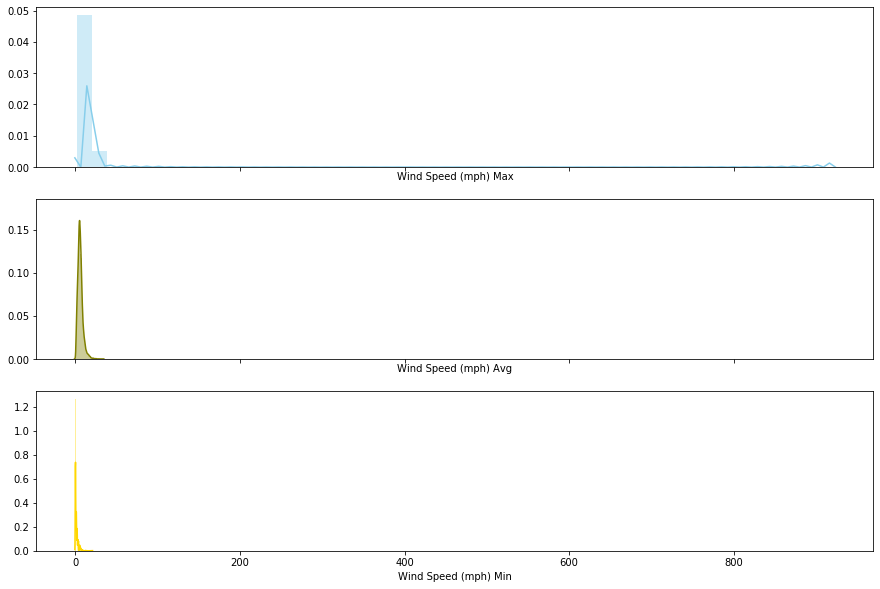

In [499]:
plt.figure(figsize=(12, 6))
f, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
sn.distplot( df["Wind Speed (mph) Max"] , color="skyblue", ax=axes[0])
sn.distplot( df["Wind Speed (mph) Avg"] , color="olive", ax=axes[1])
sn.distplot( df["Wind Speed (mph) Min"] , color="gold", ax=axes[2])

We can quickly see that high wind speed have an impact over the water tide as we may expect.

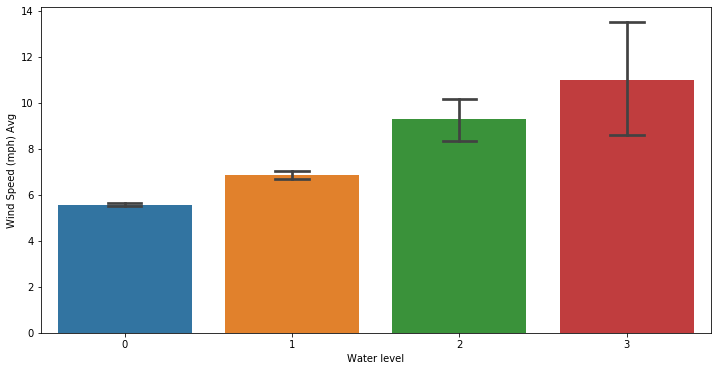

In [500]:
plt.figure(figsize=(12, 6))
sn.barplot(x="Water level", y="Wind Speed (mph) Avg", data=df, capsize=.2)

In [501]:
df.head()

,Temperature (° C) Max,Temperature (° C) Avg,Temperature (° C) Min,Dew Point (° C) Max,Dew Point (° C) Avg,Dew Point (° C) Min,Humidity (%) Max,Humidity (%) Avg,Humidity (%) Min,Wind Speed (mph) Max,...,Pressure (Hg) Min,min_sea_level (cm),avg_sea_level (cm),max_sea_level (cm),Precipitation (mm),Day,Month,Year,High Water,Water level
0,5,3.000000,1,1,-12.055556,-17,87,80.0,75,23,...,29.8,6.0,56.70,87.0,21.590,1,1,1997,1,1
1,3,2.888889,1,2,-0.444444,-17,87,84.0,81,13,...,29.9,16.0,41.58,82.0,2.032,2,1,1997,1,1
2,6,4.166667,-17,2,1.666667,-17,87,80.1,0,13,...,0.0,17.0,51.58,104.0,9.906,3,1,1997,1,1
3,7,4.833333,2,5,1.777778,-17,100,84.4,81,17,...,29.5,19.0,62.75,120.0,0.000,4,1,1997,1,2
4,6,4.666667,3,2,2.111111,1,87,82.9,81,7,...,29.6,-2.0,50.67,95.0,0.000,5,1,1997,1,1


The pressure feature is centered around 30 but there is some outliers, which are obviously anomalies. Let's remove what is outside the [20, 40] range, once again based on historical data. 

<Figure size 864x432 with 0 Axes>

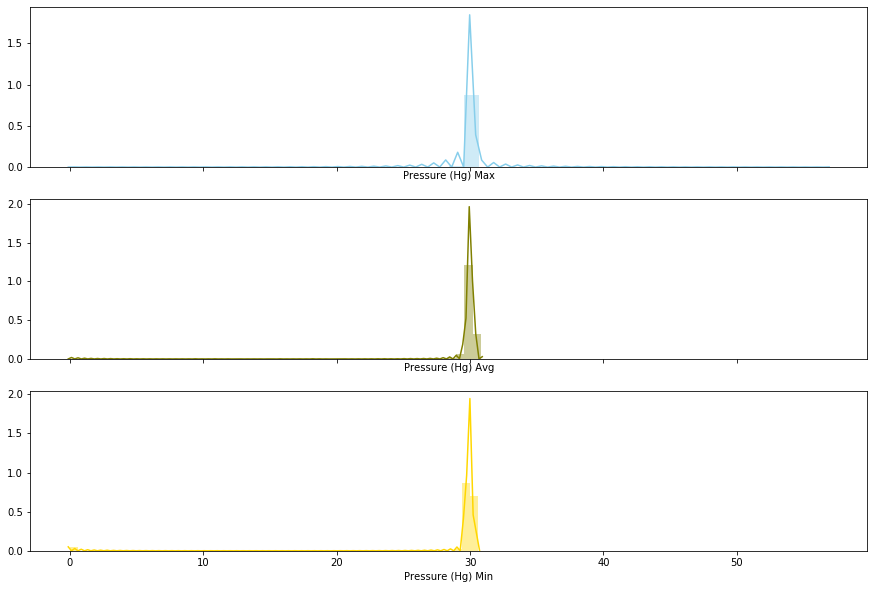

In [502]:
plt.figure(figsize=(12, 6))
f, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
sn.distplot( df["Pressure (Hg) Max"] , color="skyblue", ax=axes[0])
sn.distplot( df["Pressure (Hg) Avg"] , color="olive", ax=axes[1])
sn.distplot( df["Pressure (Hg) Min"] , color="gold", ax=axes[2])

Regarding the dew point, this is just calculated using the temperature (hence the high Pearson correlation value) so we're just going to drop it.

We can check the correlations between parameters trough the correlation heatmap:

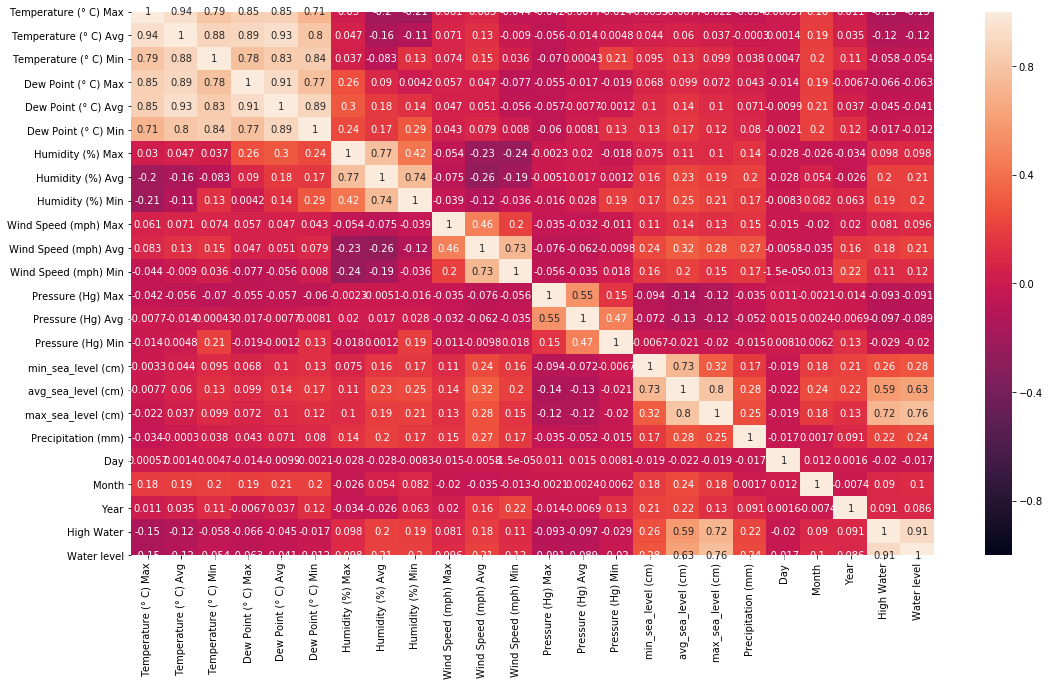

In [503]:
correlations = df.corr() # get the correlations from the dataset
plt.figure(figsize=(18, 10))
sn.heatmap(correlations, vmin =-1, vmax=1, annot=True) # plot trough seaborn

We can clearly see that some varaibles are not particularly useful to our analysis, having close to zero correlations, like the day or the temperature. 

# Feature engineering

Let's start by dropping the dew point variable and the Water level:

In [504]:
df = df.drop(['Dew Point (° C) Max', 'Dew Point (° C) Min', 'Dew Point (° C) Avg', 'Water level', 'Day'], axis=1)

We can now solve the errors we've identified previously during our graphical analysis.

In [505]:
# Remove the errors in the pressure columns
def pressure_cleaner(row, i, df):
    if row['Pressure (Hg) Max'] > 40 or row['Pressure (Hg) Max'] < 25:
        df.at[i, 'Pressure (Hg) Max'] = None
    if row['Pressure (Hg) Min'] > 40 or row['Pressure (Hg) Min'] < 25:
        df.at[i, 'Pressure (Hg) Min'] = None
    if row['Pressure (Hg) Avg'] > 40 or row['Pressure (Hg) Avg'] < 25:
        df.at[i, 'Pressure (Hg) Avg'] = None

# Remove the errors in the WindSpeed columns
def wind_cleaner(row, i, df):
    if row['Wind Speed (mph) Max'] > 35:
        df.at[i, 'Wind Speed (mph) Max'] = None
    if row['Wind Speed (mph) Avg'] > 35:
        df.at[i, 'Wind Speed (mph) Avg'] = None
    if row['Wind Speed (mph) Min'] > 35:
        df.at[i, 'Wind Speed (mph) Min'] = None

# Remove the errors in the Temperature columns
def temp_cleaner(row, i, df):
    if (row['Temperature (° C) Max'] >= 37) or (row['Temperature (° C) Max'] > 25 and (row['Month'] == '01' or int(row['Month']) == '11' or int(row['Month']) == '12')):
        df.at[i, 'Temperature (° C) Max'] = None 
    if row['Temperature (° C) Min'] < -12:
        df.at[i, 'Temperature (° C) Min'] = None
        
for i, row in df.iterrows():
    pressure_cleaner(row, i, df)
    wind_cleaner(row, i, df)
    temp_cleaner(row, i, df)

We've set to none every value which appeared unrealistic, but now we have to deal with those missing values. We can either delete the row, the entire column or fill the missing value with something new. Let's take a look at the missing values for each feature:

In [506]:
df.isnull().sum()

Temperature (° C) Max     15
Temperature (° C) Avg      0
Temperature (° C) Min    241
Humidity (%) Max           0
Humidity (%) Avg           0
Humidity (%) Min           0
Wind Speed (mph) Max     106
Wind Speed (mph) Avg       0
Wind Speed (mph) Min       0
Pressure (Hg) Max         12
Pressure (Hg) Avg         38
Pressure (Hg) Min        221
min_sea_level (cm)        20
avg_sea_level (cm)        20
max_sea_level (cm)        20
Precipitation (mm)         0
Month                      0
Year                       0
High Water                 0
dtype: int64

Some columns are missing a bit of values. In particular, we can just drop every row whereas the sea level is missing, since it's our target.

In [507]:
df = df.dropna(subset=['avg_sea_level (cm)'])

Let's check again for see what is left as NaN:

In [508]:
df.isnull().sum()

Temperature (° C) Max     15
Temperature (° C) Avg      0
Temperature (° C) Min    241
Humidity (%) Max           0
Humidity (%) Avg           0
Humidity (%) Min           0
Wind Speed (mph) Max     106
Wind Speed (mph) Avg       0
Wind Speed (mph) Min       0
Pressure (Hg) Max         12
Pressure (Hg) Avg         38
Pressure (Hg) Min        221
min_sea_level (cm)         0
avg_sea_level (cm)         0
max_sea_level (cm)         0
Precipitation (mm)         0
Month                      0
Year                       0
High Water                 0
dtype: int64

We can fill the missing values using the median. In particular, due to high variablity of the data over the seasons, we'll fill it with respect to the month. We can do this trough a restricted dataset generated trough a query. 

In [509]:
# return the median w.r.t the month
def month_median(month, feature):
    df_month = df.query('Month == "'+str(month)+'"')
    month_median = df_month[feature].median()
   
    return month_median

def fill_NaN(dataset):
    clmn = list(dataset.head()) 
    for col in clmn:
        for j, row in dataset.iterrows():
            if math.isnan(row[col]):
                dataset.at[j, col] = month_median(int(row['Month']), col)
                
                
    return dataset
                
df = fill_NaN(df)

In [510]:
df.isnull().sum()

Temperature (° C) Max    0
Temperature (° C) Avg    0
Temperature (° C) Min    0
Humidity (%) Max         0
Humidity (%) Avg         0
Humidity (%) Min         0
Wind Speed (mph) Max     0
Wind Speed (mph) Avg     0
Wind Speed (mph) Min     0
Pressure (Hg) Max        0
Pressure (Hg) Avg        0
Pressure (Hg) Min        0
min_sea_level (cm)       0
avg_sea_level (cm)       0
max_sea_level (cm)       0
Precipitation (mm)       0
Month                    0
Year                     0
High Water               0
dtype: int64

# Binary Classification

Let's split our data in two dataset: the train dataset which contain our training data, and the target dataset which contains the value we want to predict:

In [514]:
# split labels and data
def data_label_split(dataset):
    Y = dataset.copy()
    Y = Y.iloc[:, np.r_[12:15, 18]]
    X = dataset.copy()
    X = X.iloc[:, np.r_[0:12, 15:18]]
    return X, Y

#X, Y = data_label_split(df_fill)
X, Y = data_label_split(df)

In [389]:
# split labels and data
def data_label_split(dataset):
    Y = dataset.copy()
    Y = Y.iloc[:, np.r_[15:18, 22]]
    X = dataset.copy()
    X = X.iloc[:, np.r_[0:15, 18:22]]
    return X, Y

#X, Y = data_label_split(df_fill)
X, Y = data_label_split(df)

We can split our data as Train, validation and Test trough the train_test_split function of Sklearn. We'll use the Training set to train our model and the validation set to evaluate its performace and tune it's hyperparameters. Once we have choose our model, we'll check its generalization performance trough the test set. 

In [515]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, shuffle=False)

Let's import our models:

In [516]:
# Import libraries for classification 
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold 
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

For our binary classification analysis, we'll try to predict whether or not High water will occur.

From what we've seen previously, the data was imbalanced, with a proportion of 4:1. This means that for example our model might get up to 80% accuracy just by always predict 0: this means that a naive algorithm that always flag "no High water" would obtain an decent accuracy without actually having learnt anything except the statistical property of our data (which is trivial with enough observation). Therefore we'll evaluate our model using not only accuracy but also Precision and Recall. 

To solve the imbalance issue, I opted (after trying different optons) to oversample the class with the lowest amount of data (that is, the '1'). For doing this we use SMOTE(). Smote is a third party libraries which allows us to sample from a distribution generated from our data additional entries, to balance out our dataset. An example in the difference of performance will appear more clear using a ROC curve later on.

In [517]:
from imblearn.over_sampling import SMOTE

smt = SMOTE()
# upsaple the dataset
X_train_up, Y_train_up = smt.fit_sample(X_train, Y_train["High Water"])

C:\Users\zanet\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


We'll run different models to check what works better for Us. To find the best hyperparameters I'll use a GridSearch, which may take a long time depending on the hardware you're running this on.

In [201]:
#run Logistic Regression with L2 regularization
logreg = linear_model.LogisticRegression('l2', solver='lbfgs', max_iter=10000)

scores = cross_val_score(logreg, X_train_up, Y_train_up, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.77 (+/- 0.03)


In [202]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=5)

# Parameters grid for Grid Search
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.00001, 5e-05, 0.0001, 0.0005,]}

GSadaDTC = GridSearchCV(adaDTC, param_grid = param_grid, cv=kfold, scoring="accuracy", n_jobs= 10, verbose = 1)

GSadaDTC.fit(X_train_up, Y_train_up)
ada_best = GSadaDTC.best_estimator_

print("Accuracy:", GSadaDTC.best_score_)
print("Best parameters:", GSadaDTC.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 244 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done 640 out of 640 | elapsed:   12.9s finished


Accuracy: 0.8600897204949133
Best parameters: {'algorithm': 'SAMME', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 1e-05, 'n_estimators': 1}


In [203]:
#ExtraTrees classifier
ExtC = ExtraTreesClassifier()

# Parameters grid for Grid Search
param_grid = {"max_depth": [10, 20, 50],
              "max_features": [2, 3],
              "min_samples_split": [5, 10],
              "min_samples_leaf": [1, 2],
              "bootstrap": [False],
              "n_estimators" :[100, 200, 300],
              "criterion": ["gini"]}


GSsExtC = GridSearchCV(ExtC,param_grid = param_grid, cv=kfold, scoring="accuracy", n_jobs= 10, verbose = 1)

GSsExtC.fit(X_train_up,Y_train_up)
ExtC_best = GSsExtC.best_estimator_


print("Accuracy: ", GSsExtC.best_score_)
print("Best parameters:", GSsExtC.best_params_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   31.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 720 out of 720 | elapsed:  3.1min finished


Accuracy:  0.9303905203393794
Best parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [204]:
# Random Forest Classifier
RFC = RandomForestClassifier()

# Parameters grid for Grid Search
param_grid = {"max_depth": [10, 15, 20, 30],
              "max_features": [1, 3, 5],
              "min_samples_split": [1, 5, 10],
              "min_samples_leaf": [1, 3],
              "bootstrap": [False],
              "n_estimators" :[ 100, 200, 500],
              "criterion": ["gini"]}

GSRFC = GridSearchCV(RFC,param_grid = param_grid, cv=kfold, scoring="accuracy", n_jobs= 10, verbose = 1)

GSRFC.fit(X_train_up, Y_train_up)
RFC_best = GSRFC.best_estimator_


print("Accuracy: ", GSRFC.best_score_)
print("Best parameters:", GSRFC.best_params_)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  60 tasks      | elapsed:   13.8s
[Parallel(n_jobs=10)]: Done 258 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 508 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 858 tasks      | elapsed:  8.4min
[Parallel(n_jobs=10)]: Done 1308 tasks      | elapsed: 14.6min
[Parallel(n_jobs=10)]: Done 1858 tasks      | elapsed: 22.8min
[Parallel(n_jobs=10)]: Done 2160 out of 2160 | elapsed: 28.7min finished


Accuracy:  0.9200262615093457
Best parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 30, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [205]:
# Gradient boosting classifier
GBC = GradientBoostingClassifier()

# Parameters grid for Grid Search
gparam_grid = {'loss' : ["deviance"],
              'n_estimators' : [ 200, 500, 1000],
              'learning_rate': [.01, .1, .25, 0.5], 
              'max_depth': [2, 5, None],
              'min_samples_leaf': [50, 100, 125],
              'max_features': [1, 0.5,  0.1] 
              }


GSGBC = GridSearchCV(GBC,param_grid = gparam_grid, cv=kfold, scoring="accuracy", n_jobs= 10, verbose = 1)

GSGBC.fit(X_train_up, Y_train_up)

GBC_best = GSGBC.best_estimator_

# Best score
print("accuracy: ",GSGBC.best_score_)

print("Best parameters set found:", GSGBC.best_params_)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  8.0min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 24.2min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 33.1min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 53.9min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 72.7min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 90.7min
[Parallel(n_jobs=10)]: Done 3240 out of 3240 | elapsed: 91.8min finished


accuracy:  0.9143669745951415
Best parameters set found: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': None, 'max_features': 0.1, 'min_samples_leaf': 50, 'n_estimators': 200}


In [429]:
# Support Vector machine classifier
SVMC = SVC(probability=True)
# Parameters grid for Grid Search
param_grid = {'kernel': ['rbf'], 
                  'gamma':  [0.01, 0.05, 0.1],
                  'C': [100, 200,300]}

GSSVMC = GridSearchCV(SVMC,param_grid = param_grid, cv=kfold, scoring="accuracy", n_jobs= 10, verbose = 1)

GSSVMC.fit(X_train_up, Y_train_up)

SVMC_best = GSSVMC.best_estimator_

print("Accuracy: ",GSSVMC.best_score_)
print("Best parameters:", GSSVMC.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:  5.6min finished


Accuracy:  0.9359538991748462
Best parameters: {'C': 100, 'gamma': 0.05, 'kernel': 'rbf'}


In [208]:
# Bagging - Voting classifier
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=10)

We've run our analysis and found our best hyperparameters, so we can now train our best models on the dataset and see how they perform on the validation set.

In [518]:
# Logistic Regression
logreg.fit(X_train_up, Y_train_up)
Y_pred_log = logreg.predict(X_val)
logreg.fit(X_train, Y_train["High Water"])
Y_pred_log_no = logreg.predict(X_val)

#ADAboost
ada_best.fit(X_train_up, Y_train_up)
Y_pred_ada = ada_best.predict(X_val)
ada_best.fit(X_train, Y_train["High Water"])
Y_pred_ada_no = ada_best.predict(X_val)

#Extra Trees Classifier
ExtC_best.fit(X_train_up, Y_train_up)
Y_pred_extC = ExtC_best.predict(X_val)
ExtC_best.fit(X_train, Y_train["High Water"])
Y_pred_extC_no = ExtC_best.predict(X_val)

# Random Forest
RFC_best.fit(X_train_up, Y_train_up)
Y_pred_rfc = RFC_best.predict(X_val)
RFC_best.fit(X_train, Y_train["High Water"])
Y_pred_rfc_no = RFC_best.predict(X_val)

#XGB
GBC_best.fit(X_train_up, Y_train_up)
Y_pred_xgb = GBC_best.predict(X_val)
GBC_best.fit(X_train, Y_train["High Water"])
Y_pred_xgb_no = GBC_best.predict(X_val)

# SVM
SVMC_best.fit(X_train_up, Y_train_up)
Y_pred_svc = SVMC_best.predict(X_val)
SVMC_best.fit(X_train, Y_train["High Water"])
Y_pred_svc_no = SVMC_best.predict(X_val)

#Voting Classifier
votingC.fit(X_train_up, Y_train_up)
Y_pred_vote = votingC.predict(X_val)
votingC.fit(X_train, Y_train["High Water"])
Y_pred_vote_no = votingC.predict(X_val)

To plot the ROC curve we need the false positive rate and the true positive rate. To obtain this we can just use the roc_curve function from Sklearn. A way to compare classifier is then to evaluate their AUC (Area Under the Curve). The greater the area, the better the Precision/Recall values for the model.

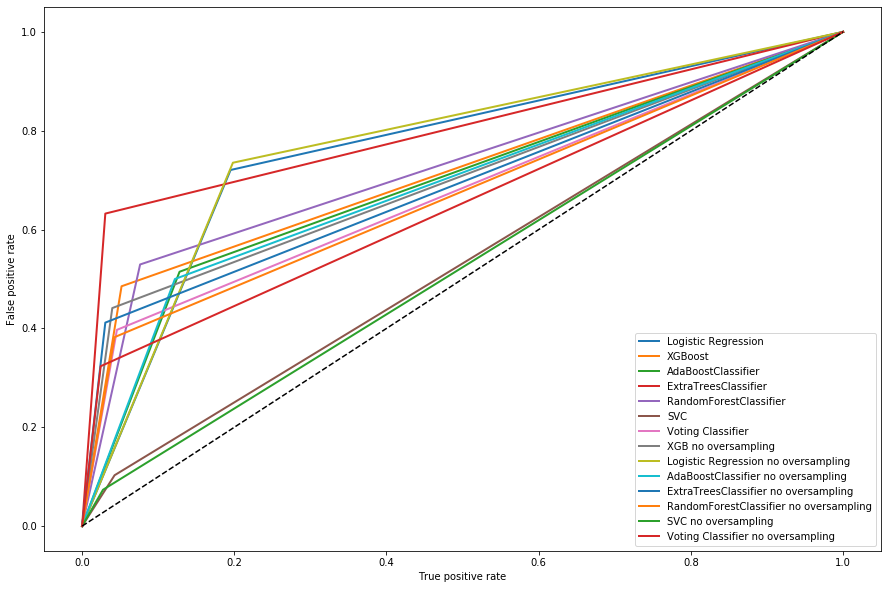

In [519]:
from sklearn.metrics import roc_curve, roc_auc_score

# Gets FP, TP rates from the model's predictions
fpr_log, tpr_log, treshold_log = roc_curve(Y_val["High Water"], Y_pred_log)
fpr_xgb, tpr_xgb, treshold_xgb = roc_curve(Y_val["High Water"], Y_pred_xgb)
fpr_ada, tpr_ada, treshold_ada = roc_curve(Y_val["High Water"], Y_pred_ada)
fpr_extC, tpr_extC, treshold_extC = roc_curve(Y_val["High Water"], Y_pred_extC)
fpr_rfc, tpr_rfc, treshold_rfc = roc_curve(Y_val["High Water"], Y_pred_rfc)
fpr_svc, tpr_svc, treshold_svc = roc_curve(Y_val["High Water"], Y_pred_svc)
fpr_vote, tpr_vote, treshold_vote = roc_curve(Y_val["High Water"], Y_pred_vote)
fpr_xgb_no, tpr_xgb_no, treshold_xgb_no = roc_curve(Y_val["High Water"], Y_pred_xgb_no)
fpr_log_no, tpr_log_no, treshold_log_no = roc_curve(Y_val["High Water"], Y_pred_log_no)
fpr_ada_no, tpr_ada_no, treshold_ada_no = roc_curve(Y_val["High Water"], Y_pred_ada_no)
fpr_extC, tpr_extC_no, treshold_extC_no = roc_curve(Y_val["High Water"], Y_pred_extC_no)
fpr_rfc_no, tpr_rfc_no, treshold_rfc_no = roc_curve(Y_val["High Water"], Y_pred_rfc_no)
fpr_svc_no, tpr_svc_no, treshold_svc_no = roc_curve(Y_val["High Water"], Y_pred_svc_no)
fpr_vote_no, tpr_vote_no, treshold_vote_no = roc_curve(Y_val["High Water"], Y_pred_vote_no)

# Plot the ROC curve
plt.figure(figsize=(15, 10))
plt.plot(fpr_log,tpr_log, linewidth=2, label=None)
plt.plot(fpr_xgb, tpr_xgb, linewidth=2, label=None)
plt.plot(fpr_ada, tpr_ada, linewidth=2, label=None)
plt.plot(fpr_extC, tpr_extC, linewidth=2, label=None)
plt.plot(fpr_rfc, tpr_rfc, linewidth=2, label=None)
plt.plot(fpr_svc, tpr_svc, linewidth=2, label=None)
plt.plot(fpr_vote, tpr_vote, linewidth=2, label=None)
plt.plot(fpr_xgb_no, tpr_xgb_no, linewidth=2, label=None)
plt.plot(fpr_log_no, tpr_log_no, linewidth=2, label=None)
plt.plot(fpr_ada_no, tpr_ada_no, linewidth=2, label=None)
plt.plot(fpr_extC, tpr_extC_no, linewidth=2, label=None)
plt.plot(fpr_rfc_no, tpr_rfc_no, linewidth=2, label=None)
plt.plot(fpr_svc_no, tpr_svc_no, linewidth=2, label=None)
plt.plot(fpr_vote_no, tpr_vote_no, linewidth=2, label=None)
plt.plot([0,1], [0,1], 'k--')
plt.legend(['Logistic Regression', 'XGBoost', 'AdaBoostClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier',  'SVC', 'Voting Classifier', 'XGB no oversampling', 'Logistic Regression no oversampling', 
            'AdaBoostClassifier no oversampling', 'ExtraTreesClassifier no oversampling', 'RandomForestClassifier no oversampling',  'SVC no oversampling', 'Voting Classifier no oversampling'])
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.show()

From our ROC we can choose the best model, where the dashed line in the middle is the expected curve for random guessing. We can see that support vector models are performing pretty badly, while the ones with the greates AUC are logistic regression models and the Extra Trees Classifier. We can measure their AUC trough the roc_auc_score function of Scikit Learn.

In [520]:
print("AUC score Extra Trees Classifier: ", roc_auc_score(Y_val["High Water"], Y_pred_extC))
print("AUC score Logistic Regression classifier: ", roc_auc_score(Y_val["High Water"], Y_pred_log))

AUC score Extra Trees Classifier:  0.7689203730272597
AUC score Logistic Regression classifier:  0.7627331420373028


While they have similar score, we can clearly see from the plot that their precision and recall are quite different:

In [521]:
from sklearn.metrics import classification_report

print("LOGISTIC REGRESSION CLASSIFICATION REPORT:")
print(classification_report(Y_val["High Water"], Y_pred_log))

print("EXTRA TREES CLASSIFICATION REPORT:")
print(classification_report(Y_val["High Water"], Y_pred_extC))

LOGISTIC REGRESSION CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       328
           1       0.43      0.72      0.54        68

    accuracy                           0.79       396
   macro avg       0.68      0.76      0.70       396
weighted avg       0.85      0.79      0.81       396

EXTRA TREES CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       328
           1       0.58      0.63      0.61        68

    accuracy                           0.86       396
   macro avg       0.75      0.77      0.76       396
weighted avg       0.86      0.86      0.86       396



Due to the nature of our problem, we would prefer an higher precision due to the fact that false negative (predicting no high water while it happens) might create discomfort, while false positive are just a bother but don't generate particular problems. We therefore choose the Extra Trees Classifier. We can fianlly evaluate our model on the test set.

In [446]:
ExtC_best.fit(X_train_up, Y_train_up)

print("Test set accuracy: ", ExtC_best.score(X_test, Y_test["High Water"]))

Test set accuracy:  0.8838383838383839


We obtained around 88% accuracy on the test set, which is not too bad, however the precision/recall values leave to be desired. 

# Regression

Let's see if we can obtain a model that is able to predict the exact water level trough regression. We will try to predict the maximum water level value, since it's the most informative one in our case. We'll then evaluate the model trough the use on Mean Absolute Error and Root Mean Squared Error. 
The Mean Absolute Error is just the averaged difference between the forecasted value and the observed one. Mean absolute error is however not sensitive to outliers. The Root Mean Squared Error takes the square root of the Mean Squared Error, which is the averaged squared difference between forecasted value and the observed one. MSE & RMSE are useful when you want to see if the outliers are impacting our prediction, as it might be the case with the exceptional high water values.

Let's start by creating a baseline naive model, which will tell us how well our model is performing with respect to a model which always predict the average of our target value.

In [522]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

Y_pred_naive = []

# Fill a vector with the mean value
for i in range (0, len(Y_val["max_sea_level (cm)"])):
    mean = Y_val["max_sea_level (cm)"].mean()
    Y_pred_naive.append(mean)
    
print("MAE naive model: ", mean_absolute_error(Y_val["max_sea_level (cm)"], Y_pred_naive))
print("RMSE naive model: ", sqrt(mean_squared_error(Y_val["max_sea_level (cm)"], Y_pred_naive)))

MAE naive model:  12.051652892561982
RMSE naive model:  16.017916033865088


Now that we have our naive model we can try fitting some simple and more advanced models for regression:

In [523]:
from sklearn.linear_model import Ridge, Lasso

# Ridge regression
ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(X_train,Y_train['max_sea_level (cm)'])

Y_pred_ridge = ridge_reg.predict(X_val)

print("MAE Ridge regression model: ", mean_absolute_error(Y_val["max_sea_level (cm)"], Y_pred_ridge))
print("RMSE Ridge regression model: ", sqrt(mean_squared_error(Y_val["max_sea_level (cm)"], Y_pred_ridge)))

MAE Ridge regression model:  9.336158150820497
RMSE Ridge regression model:  12.080487610890012


In [524]:
# Lasso regression
lasso_reg=Lasso(alpha=0.01)
lasso_reg.fit(X_train,Y_train['max_sea_level (cm)'])

Y_pred_lasso = lasso_reg.predict(X_val)

print("MAE Lasso regression model: ", mean_absolute_error(Y_val["max_sea_level (cm)"], Y_pred_lasso))
print("RMSE Lasso regression model: ", sqrt(mean_squared_error(Y_val["max_sea_level (cm)"], Y_pred_lasso)))

MAE Lasso regression model:  9.335463421444029
RMSE Lasso regression model:  12.079635404049242


In [525]:
from sklearn.linear_model import ElasticNetCV

#Elastic Net
alphas = [0.001, 0.01, 0.1, 0.5]
l1ratio = [0.1, 0.3,0.5, 0.9, 0.95, 0.99, 1]

elastic_cv = ElasticNetCV(cv=5, max_iter=1e7, alphas=alphas,  l1_ratio=l1ratio)

elastic = elastic_cv.fit(X_train,Y_train['max_sea_level (cm)'])
Y_pred_elastic = elastic.predict(X_val)

print("MAE ElasticNet model: ", mean_absolute_error(Y_val["max_sea_level (cm)"], Y_pred_elastic))
print("RMSE ElasticNet model: ", sqrt(mean_squared_error(Y_val["max_sea_level (cm)"], Y_pred_elastic)))

MAE ElasticNet model:  9.336639112570436
RMSE ElasticNet model:  12.081085780552097


In [ ]:
import xgboost
from scipy.stats import uniform

xgbr = xgboost.XGBRegressor()

#  Random Search XGB parameters
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(xgbr, param_distributions=param_dist, scoring='neg_mean_squared_error', n_iter=200)

rs.fit(X_train, Y_train['max_sea_level (cm)'])

In [527]:
xgbr = xgboost.XGBRegressor(gamma = 0.15, learning_rate = 0.06, max_depth = 9, min_child_weight = 3, n_estimators = 200)

xgbr.fit(X_train, Y_train['max_sea_level (cm)'])

Y_pred_xgbr = xgbr.predict(X_val)

print("MAE XGB regressor model: ", mean_absolute_error(Y_val["max_sea_level (cm)"], Y_pred_xgbr))
print("RMSE XGB regressor model: ", sqrt(mean_squared_error(Y_val["max_sea_level (cm)"], Y_pred_xgbr)))

MAE XGB regressor model:  8.615793411177819
RMSE XGB regressor model:  10.871733543929185


We've found our best model in the eXtreme Gradient Boosting. Both the MAE and the RMSE have decreased by the naive model with decent scores. However, we can see that our model is lacking in terms of predicting outliers. We can also use our regressor model to see how it performs on the binary classification problems by labelling the predictions. 

In [528]:
from sklearn.metrics import accuracy_score

# regression to binary results
def RegToClass(Y_pred_xgbr):
    Y_pred_reg = []
    for i in Y_pred_xgbr:
        if i > 80: 
            Y_pred_reg.append(1)
        else: Y_pred_reg.append(0)
    return Y_pred_reg

print("XGB REGRESSOR TO BC CLASSIFICATION REPORT:")
print(classification_report(Y_val["High Water"], RegToClass(Y_pred_xgbr)))

Y_pred_xgbr = xgbr.predict(X_test)

print("Test set accuracy: ", accuracy_score(Y_test["High Water"], RegToClass(Y_pred_xgbr)))

XGB REGRESSOR TO BC CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       328
           1       0.68      0.50      0.58        68

    accuracy                           0.87       396
   macro avg       0.79      0.73      0.75       396
weighted avg       0.86      0.87      0.87       396

Test set accuracy:  0.8333333333333334


Which is actually better to our previous classification model due to the higher precision, even considering the slightly lower accuracy. We can plot the most relevant variable trough the plot_importance function of xgboost:

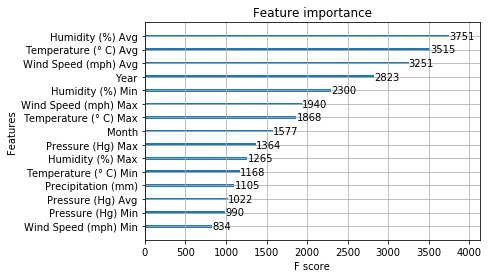

In [531]:
xgboost.plot_importance(xgbr)

We've managed to find a decent model for our data, which leave however margin for improvement. Using hourly values instead of daily might probably help our analysis, but sadly I was unable to find those for free online. The tides are also influenced by not only metereological effects but also from atmosferical effects. Overall, this was a good way to excercise data scraping, data analysis and some machine learning. Hope you find it useful, I'm always open for feedbacks! 